In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

General Workflow:
1. Read in NetCFD file to xarray object
2. Isolate weather groups
3. Get subsets of xarray objects and store into dictionary with keys for variable and weather group (location)
4. Convert xarray objects to dataframes, dropping coordinates and resetting indices

In [2]:
# File Location of NetCFD input
file_location = "./training.nc"

In [3]:
# Create datetime objects
times = pd.date_range(start='2020-10-31 00:00:00', end='2020-10-31 23:00:00', freq='H')
levels = [650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

# Column names in NetCFD
LATITUDE_NAME = "latitude"
LONGITUDE_NAME = "longitude"
TIME_NAME = "time"
TEMP_NAME = "t"
HUMID_NAME = "r"

# Read in NetCFD file into a usable dataset
dset = xr.open_dataset(file_location)

target_groups = [
    [-13, 131],
    [-13.25, 131],
    [-12.75, 131],
    [-13, 131.25],
    [-13, 130.75],
    [-13.25, 131.25]
]

# Finding and isolating area we want to work with
dataset_lats = dset[LATITUDE_NAME]
dataset_lons = dset[LONGITUDE_NAME]

wxgroups = []
for idx, [target_lat, target_lon] in enumerate(target_groups):
    lat = dset[LATITUDE_NAME][(abs(dataset_lats - target_lat)).argmin()]
    lon = dset[LONGITUDE_NAME][(abs(dataset_lons - target_lon)).argmin()]
    wxgroups.append([lat, lon])

In [4]:
# Dimensions of temperature and relative humidity: time, level, latitude, longitude

xr_dataset = {}

for idx, group in enumerate(wxgroups):
    xr_dataset[("TEMP", idx)] = dset[TEMP_NAME].sel(latitude=group[0], longitude=group[1])
    xr_dataset[("RH", idx)] = dset[HUMID_NAME].sel(latitude=group[0], longitude=group[1])

In [5]:
df_dataset = {}
for i in range(6):
    df_dataset[("TEMP", i)] = xr_dataset[("TEMP", i)].to_dataframe()
    del df_dataset[("TEMP", i)]["longitude"]
    del df_dataset[("TEMP", i)]["latitude"]
    df_dataset[("TEMP", i)].reset_index(inplace=True)
    
    df_dataset[("RH", i)] = xr_dataset[("RH", i)].to_dataframe()
    del df_dataset[("RH", i)]["longitude"]
    del df_dataset[("RH", i)]["latitude"]
    df_dataset[("RH", i)].reset_index(inplace=True)
    
df_dataset[("TEMP", 0)].columns

Index(['time', 'level', 't'], dtype='object')

(1000.0, 650.0)

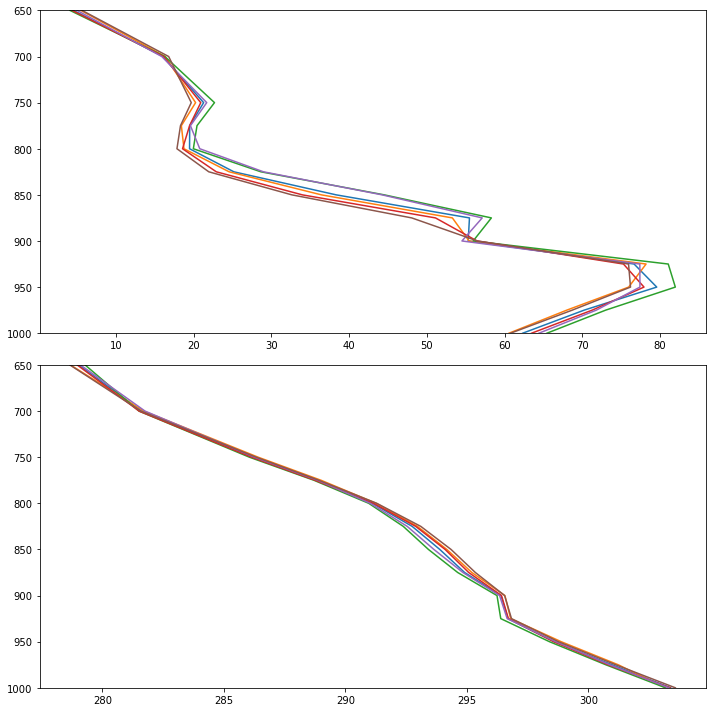

In [6]:
fig1 = plt.figure(figsize=(10, 10))
fig1.set_tight_layout(True)
ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_subplot(2,1,2)


for i in range(6):
    r = df_dataset[("RH", i)]
    t = df_dataset[("TEMP", i)]

    rss = r.loc[r["time"] == times[0]]
    ax1.plot(rss["r"], rss["level"])
    
    tss = t.loc[t["time"] == times[0]]
    ax2.plot(tss["t"], tss["level"])


ax1.set_ylim(1000, 650)  # decreasing levels
ax2.set_ylim(1000, 650)  